<h1 style="font-weight:bold">Qual o Efeito da Legalização da Maconha na Taxa de Criminalidade ao Longo do Tempo?</h1>

<hr/>
<h2>Parte 3 - Construção e avaliação do modelo</h2>
<hr/>

<h3>1) INTRODUÇÃO</h3>

<h3>1.1) Carregando os Pacotes Usados Neste Jupyter Notebook</h3>


In [17]:
import warnings
warnings.filterwarnings("ignore")

# Imports para manipulação e visualização de dados
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Imports para Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Imports para Análise de Séries Temporais
import pickle
import calendar
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf

# Imports para formatação dos gráficos
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
plt.style.use('fivethirtyeight')
%matplotlib inline

<hr/>

<h3>2) MODELAGEM PREDITIVA </h3>

Vamos iniciar nosso trabalho criando um modelo de Machine Learning para classificação e compreendendo quais são as variáveis mais relevantes para prever a ocorrência de prisões.

In [2]:
# Carregando os dados
df_prisoes = pd.read_csv('dados/df_prisoes_parte2.csv')

In [3]:
# Shape
df_prisoes.shape

(6226, 14)

In [4]:
# Dados
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,4,13,4,8
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4


In [5]:
# Criamos uma lista de razões para as prisões
charge_description_list = list(df_prisoes['Charge Description'].unique())

In [6]:
# Ordenamos a lista
charge_description_list.sort()

In [7]:
# Dados
charge_description_list

['attempt - sell/furnish/etc marijuana',
 'cultivate >6 marij plants viol envrnt law',
 'cultivating <6 marijuana plants',
 'furnishing marijuana to minor over 14 yrs',
 'give/transport/etc < 28.5 grams marijuana',
 'induce/etc minor to use/sell marijuana',
 'minor poss 28.5+ grams marijuana/school',
 'minor poss < 28.5 grams marijuana/school',
 'poss for sale of marijuana to a minor',
 'poss marijuana or concentrated cannabis',
 'poss of more than 28.5 grams of marijuana',
 'poss open cont/packg marij drivr/passnger',
 'poss/sale marij ovr 21 employ per 20/belw',
 'poss/smoke/ingest marij school/daycare/yc',
 'possess 28.5 grams or less of marijuana',
 'possess 28.5 grams or less of marijuana**',
 'possess marijuana for sale',
 'possess marijuana for sale under age 18',
 'possess of marijuana while driving veh',
 'possession marijuana for sale',
 'possession of marijuana in school',
 'sale/offer to sell/transport marijuana',
 'sale/trans >28.5g marijuana or >4g',
 'sale/transport mari

Agora criaremos nossa variável target (venda ou não de maconha).

In [8]:
# Aplicamos função map para identificar venda de maconha
target = df_prisoes['Charge Description'].map(lambda x: 'sell' if 'sale' in x else x)

In [9]:
# Então identificamos venda ou não de maconha
target = target.map(lambda x: 'sell' if 'sell' in x else x)
target = target.map(lambda x: 'not sell' if 'sell' not in x else x)

In [10]:
# Contamos os registros de cada classe e mostramos como proporção
target.value_counts(normalize = True)

sell        0.616929
not sell    0.383071
Name: Charge Description, dtype: float64

Como as classes são um pouco desequilibradas, vamos estratificá-las para que haja a mesma proporção de observações de 'venda' e 'não venda' nos conjuntos de dados de treino e teste, mais a frente.

In [11]:
# Inclui a variável no dataframe
df_prisoes['target'] = target

In [12]:
# Fazemos o encoding substituindo as classes por valores 0 ou 1
df_prisoes['target'] = df_prisoes['target'].map(lambda x: 1 if x == 'sell' else 0)

In [13]:
# Dados
df_prisoes.head()

,Arrest Date,Time,Area Name,Age,Sex Code,Descent Code,Arrest Type Code,Charge Description,latitude,longitude,loja_0.5_milha,loja_1_milha,escola_0.5_milha,escola_1_milha,target
0,2019-03-09,2015.0,Hollywood,29,M,O,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5,1
1,2019-03-09,2015.0,Hollywood,25,M,B,F,possession marijuana for sale,34.1016,-118.3350,7,8,2,5,1
2,2019-04-21,2115.0,Wilshire,42,M,B,F,poss/sale marij ovr 21 employ per 20/belw,34.0838,-118.3614,4,13,4,8,1
3,2019-05-01,1045.0,Pacific,26,M,B,F,sale/trans >28.5g marijuana or >4g,33.9428,-118.4054,0,0,0,0,1
4,2019-05-01,5.0,N Hollywood,27,M,B,F,sale/trans >28.5g marijuana or >4g,34.1667,-118.3965,0,1,3,4,1


Variável target incluída. Vamos checar algumas correlações.

<AxesSubplot:>

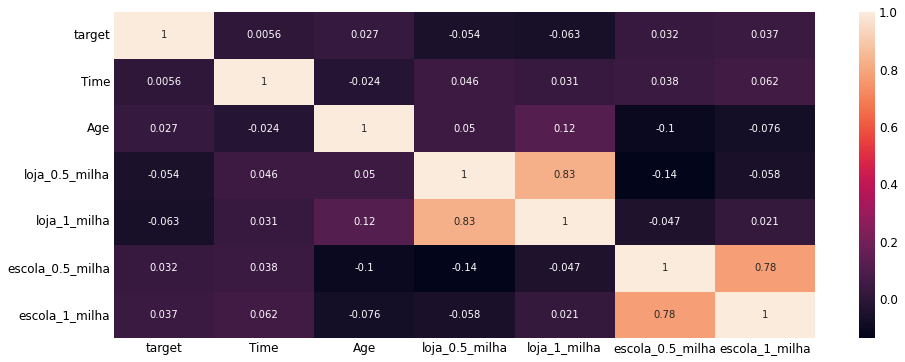

In [19]:
# Correlação entre as variáves de distância do ponto de venda
df_corr = df_prisoes[['target', 'Time', 'Age', 'loja_0.5_milha', 'loja_1_milha', 'escola_0.5_milha', 'escola_1_milha']]

plt.figure(figsize=(14, 6))
sns.heatmap(df_corr.corr(), annot=True)

As variáveis que nós criamos `loja_0.5_milha`, `loja_1_milha`, `escola_0.5_milha`, `escola_1_milha`  estão altamente correlacionadas e isso é ruim para o modelo.

In [20]:
# Remove variáveis e coloca o restante em X
X = df_prisoes.drop(['Arrest Date', 'Charge Description', 'target', 'loja_0.5_milha', 'escola_0.5_milha'], 1)

In [21]:
# Remove variáveis e coloca o restante em X
X = df_prisoes.drop(['Arrest Date', 'Charge Description', 'target', 'loja_0.5_milha', 'escola_0.5_milha'], 1)

In [22]:
# Criamos variáveis dummy para as variáveis categóricas, pois assim trabalhamos apenas com variáveis numéricas
X = pd.get_dummies(X)

In [23]:
# Dados
X.head()

,Time,Age,latitude,longitude,loja_1_milha,escola_1_milha,Area Name_77th Street,Area Name_Central,Area Name_Devonshire,Area Name_Foothill,...,Descent Code_F,Descent Code_G,Descent Code_H,Descent Code_O,Descent Code_P,Descent Code_W,Descent Code_X,Arrest Type Code_F,Arrest Type Code_I,Arrest Type Code_M
0,2015.0,29,34.1016,-118.3350,8,5,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2015.0,25,34.1016,-118.3350,8,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2115.0,42,34.0838,-118.3614,13,8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1045.0,26,33.9428,-118.4054,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5.0,27,34.1667,-118.3965,1,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Separamos y
y = df_prisoes['target']

# Dados
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [26]:
# Divisão em dados de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state = 42, stratify = y)

In [27]:
# Cria o modelo
modelo_lr = LogisticRegression()

In [28]:
# Treinamento do modelo
modelo_lr.fit(X_treino, y_treino)

LogisticRegression()

In [29]:
# Avalia a acurácia em treino
acc_treino = modelo_lr.score(X_treino, y_treino)
print(f'Acurácia em Treino: {round(acc_treino, 2) * 100}')

Acurácia em Treino: 88.0


In [30]:
# Avalia a acurácia em teste
acc_teste = modelo_lr.score(X_teste, y_teste)
print(f'Acurácia em Teste: {round(acc_teste, 2) * 100}')

Acurácia em Teste: 90.0


Estamos com boa acurácia. Vamos extrair os coeficientes e realizar mais algumas análises.

In [33]:
# Coeficientes beta do modelo
beta = modelo_lr.coef_[0]

# Atributos
atributos = list(X.columns)


# Criamos um dataframe associando os coeficientes aos atributos e ajustamos o índice
beta_df = pd.DataFrame({'atributos': atributos, 'beta' :beta})
beta_df.set_index('atributos', inplace = True)

# Dados
beta_df.head()

,beta
atributos,
Time,-0.000316
Age,-0.026792
latitude,-0.384416
longitude,-0.122456
loja_1_milha,-0.104165


In [35]:
# Vamos extrair o Log ODD
beta_df['log_odds'] = beta_df['beta'].map(lambda x: np.exp(x))

# Ordenamos os dados
beta_df = beta_df.sort_values('log_odds', ascending = False)

# Dados
beta_df.head(10)

,beta,log_odds
atributos,,
Arrest Type Code_F,3.533070,34.228896
Area Name_Southeast,0.891613,2.439061
Descent Code_B,0.837634,2.310893
Area Name_Pacific,0.522064,1.685503
Sex Code_F,0.327264,1.387168
Area Name_Central,0.194716,1.214965
Area Name_Harbor,0.183709,1.201666
Area Name_77th Street,0.166752,1.181461
Area Name_Hollywood,0.123011,1.130897


Todas as variáveis são relevantes para a previsão de prisão por venda de maconha.

In [36]:
# Vamos verificar os registros de escolas a 1 milha de distância
beta_df[beta_df.index == 'escola_1_milha']

,beta,log_odds
atributos,,
escola_1_milha,0.005502,1.005517


O modelo de Regressão Logística permite extrair não apenas previsões de classe, mas também as probabilidades. Vejamos que análises podemos fazer com isso.

In [39]:
# Probabilidades da prisão por venda de maconha (classe target = 1)
prob_prisao_venda = modelo_lr.predict_proba(X_teste)[:,1]

# Probabilidades
prob_prisao_venda

array([0.1241772 , 0.93640364, 0.97823587, ..., 0.97812515, 0.98510637,
       0.93686608])

In [41]:
# Cria um dataframe com valores reais e probabilidades previstas
pred_df = pd.DataFrame({'valores_reais': y_teste, 'valores_previstos':prob_prisao_venda})

# Dados
pred_df.head()

,valores_reais,valores_previstos
1780,0,0.124177
2379,0,0.936404
3731,1,0.978236
6068,1,0.964818
4958,1,0.967546


Um Plot facilita análise e compreensão.

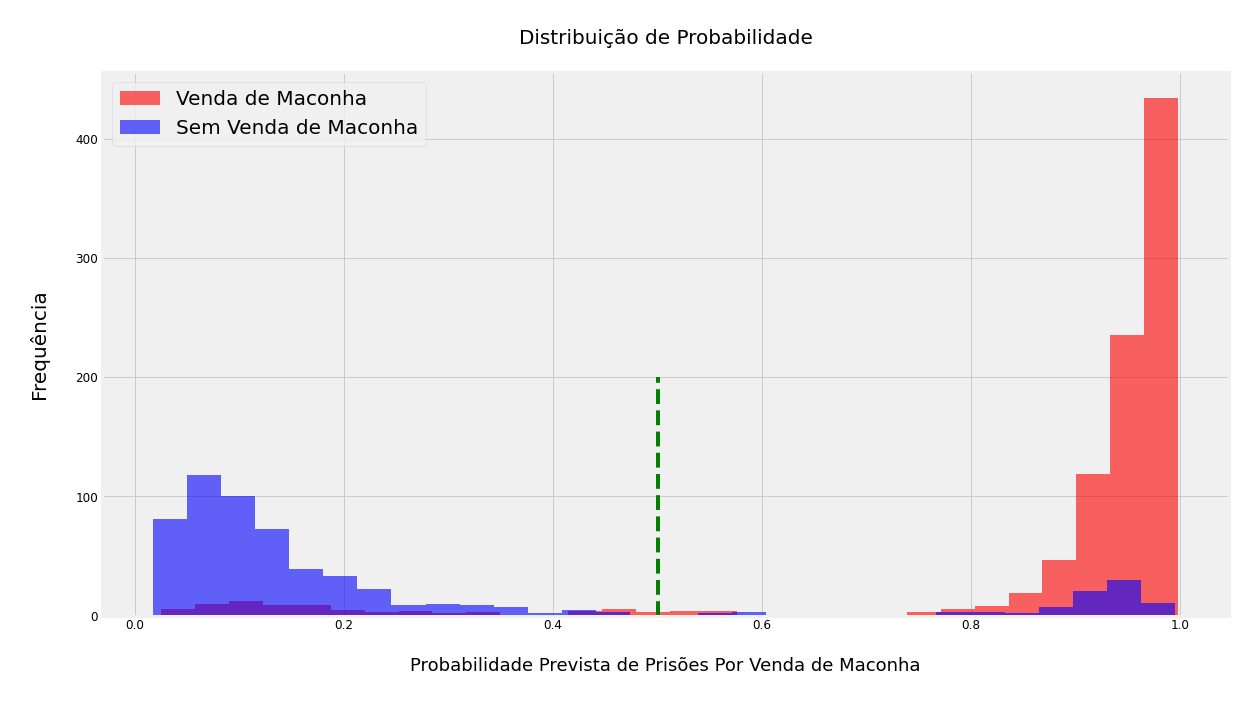

In [42]:
# Plot da Distribuição de Probabilidades

# Figura
plt.figure(figsize = (18,10))

# Histograma dos valores reais x valores previstos para a classe 1
plt.hist(pred_df[pred_df['valores_reais'] == 1]['valores_previstos'], 
         bins = 30, 
         color = 'r', 
         alpha = 0.6, 
         label = 'Venda de Maconha')

# Histograma dos valores reais x valores previstos para a classe 0
plt.hist(pred_df[pred_df['valores_reais'] == 0]['valores_previstos'],
         bins = 30,
         color = 'blue',
         alpha = 0.6,
         label = 'Sem Venda de Maconha')

# Linha central do gráfico - vline - vertical line
plt.vlines(x = 0.5, ymin = 0, ymax = 200, color = 'green', linestyle = '--')

# Labels e Legenda
plt.title('\nDistribuição de Probabilidade\n', fontsize = 20)
plt.ylabel('\nFrequência\n', fontsize = 20)
plt.xlabel('\nProbabilidade Prevista de Prisões Por Venda de Maconha\n', fontsize = 18)
plt.legend(fontsize = 20);

Será que a proximidade de um Departamento de Polícia altera o resultado? Vamos analisar.

In [43]:
# Extrai os coeficientes por nome da área
beta_df = beta_df[beta_df.index.str.contains('Area Name')].head(8)

# Dados
beta_df.head()

,beta,log_odds
atributos,,
Area Name_Southeast,0.891613,2.439061
Area Name_Pacific,0.522064,1.685503
Area Name_Central,0.194716,1.214965
Area Name_Harbor,0.183709,1.201666
Area Name_77th Street,0.166752,1.181461


Os Departamentos de Polícia na cidade de Los Angeles estão registrados aqui:
    
http://www.lapdonline.org/our_communities/content_basic_view/6279 
   
Precisamos das coordenadas para os gráficos.

In [44]:
# Latitude dos Departamentos de Polícia na cidade de Los Angeles
beta_df['latitude'] = [33.9383761, 34.097986, 33.9920067, 34.0443028, 33.7584097, 34.050264, 34.1195162, 34.1842023]

# Longitude dos Departamentos de Polícia na cidade de Los Angeles
beta_df['longitude'] = [-118.2749244, -118.331013, -118.4199295, -118.4509833, -118.2880336, -118.291531, -118.2497385, -118.3021552]


Criamos o Plot.

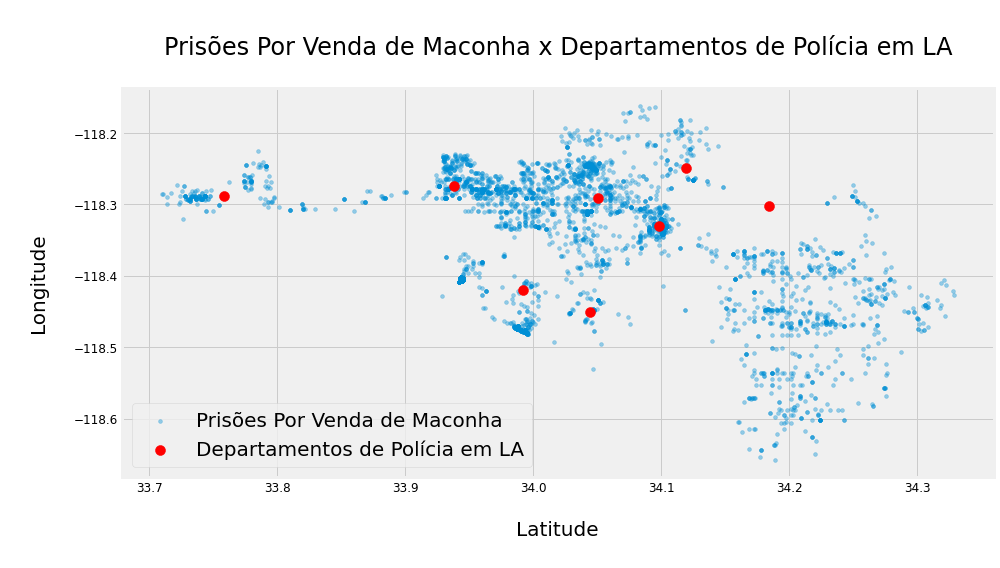

In [45]:
# Plot da classe 1 com principais atributos versus prisões por maconha

# Figura
fig, ax = plt.subplots(figsize = (14,8))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] == 1]['latitude'], 
            df_prisoes[df_prisoes['target'] == 1]['longitude'], 
            s = 15, 
            alpha = 0.4,
            label = 'Prisões Por Venda de Maconha')

# Títulos, labels e legenda
ax.scatter(beta_df['latitude'], beta_df['longitude'], color = 'red', label = 'Departamentos de Polícia em LA', s = 100)
plt.title('\nPrisões Por Venda de Maconha x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

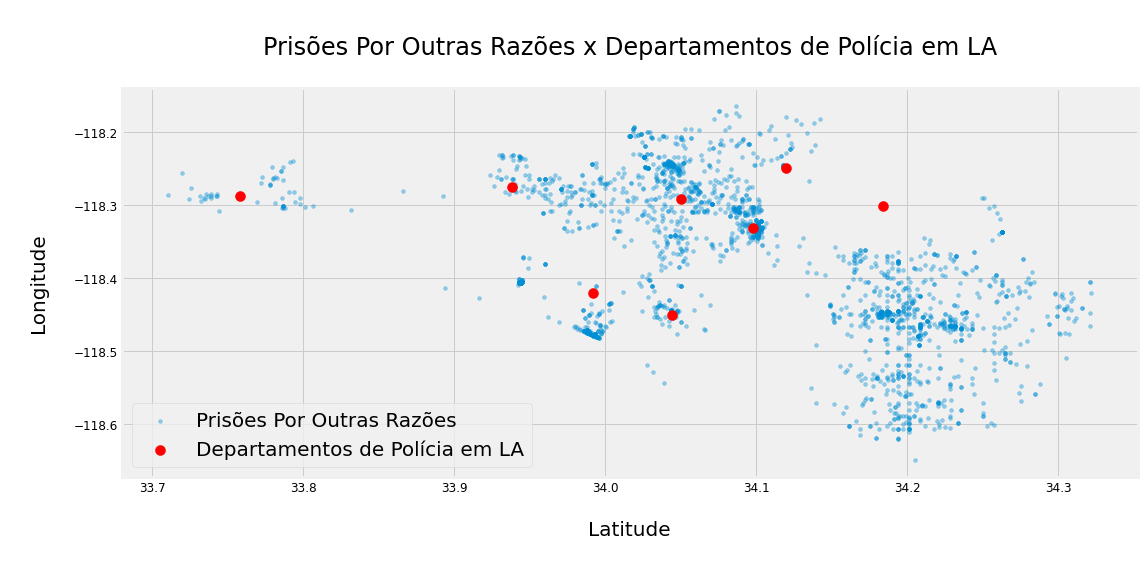

In [46]:
    # Plot da classe 0 com principais atributos versus prisões por maconha

# Figura
fig, ax = plt.subplots(figsize = (16,8))

# Plot
plt.scatter(df_prisoes[df_prisoes['target'] ==0]['latitude'], 
            df_prisoes[df_prisoes['target'] ==0]['longitude'], 
            s = 15, 
            alpha = 0.4,
            label = 'Prisões Por Outras Razões')

# Títulos, labels e legenda
ax.scatter(beta_df['latitude'], beta_df['longitude'], color = 'red', label = 'Departamentos de Polícia em LA', s = 100)
plt.title('\nPrisões Por Outras Razões x Departamentos de Polícia em LA\n', fontsize = 24)
plt.xlabel('\nLatitude\n', fontsize = 20)
plt.ylabel('\nLongitude\n', fontsize = 20)
ax.legend(fontsize = 20)
plt.tight_layout()

Como resultado, o medo de exposição à maconha para crianças e menores parece não ser um fator. Existem duas classes: vender maconha e não vender maconha, e argumenta-se que a venda de maconha expõe mais crianças à maconha. A variável **escola_1_milha** é a contagem de escolas que estão dentro de 1 milha de cada prisão. Devido às chances de log de 'escola_1_milha' iguais a uma, ter uma escola a menos de 1,6 km de uma prisão é tão provável quanto a prisão por maconha estar relacionada à venda e a não venda.